In [1]:
# %load_ext autoreload
# %autoreload 2
import joblib
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import os
import multiprocessing as mp
import gym

import tensorflow as tf
from tensorflow.keras.models import clone_model
from tensorflow.keras.losses import Huber, CategoricalCrossentropy, KLDivergence

import sys
sys.path.append('../script')
from utils import ( 
    preprocess_frame_v4, choose_action, get_lin_anneal_eps, sample_ran_action, 
    EpisodeLogger, frame_max_pooling, FRAME_CROP_SETTINGS, animate_episode_sal
)
from atari_model import (
    atari_model, atari_model_dueling, atari_model_dueling, atari_model_distr,
    fit_batch_DDQNn_PER, fit_batch_DDQNn_PER_DS
)
from replay_memory import PrioritizedReplayMemory

tf.__version__

'2.7.0'

In [2]:
# Set configuration
game = 'space_invaders'
total_train_len = 50_000      # Total no. of episodes to train
max_episode_len = None        # Max no. of frames agent is allowed to see per episode [CURRENTLY UNUSED]
state_len = 4                 # No. of stacked frames that comprise a state
train_interval = 4            # Every x actions a gradient descend step is performed
tgt_update_interval = 10_000  # Interval in terms of no. of frames after we update target model weights
eps_init = 1                  # Initial eps in eps-greedy exploration 
eps_final = 0.1               # Final eps in eps-greedy exploration
eps_final_frame = 1_000_000   # No. of frame over which eps is linearly annealed to final eps
replay_init_sz = 50_000       # Replay mem. initialization size: random policy is run for this many frames, training starts after
replay_mem_sz = 1_000_000     # Max no. of frames cached in replay memory

batch_sz = 32                 # No. of training cases (sample from replay mem.) for each SGD update
disc_rate = 0.99              # Q-learning discount factor (gamma)
n_step = 3                    # Determines multi-step learning (n=1 is simply single step learning)
# lr = 0.0000625              # Learning rate of CNN
lr = 0.00025                  # Learning rate of CNN

per_alpha = 0.5               # Exponent of priority probabilities
per_beta = 0                  # Exponent of importance sampling weights # TODO: amend code to handle [0.4, 1] 
init_tds = False              # Whether to compute td-errors for initial replay memories
crop_frame = True

# Model variants (Rainbow)
large_net = True
double_learn = True
duel_net = True
noisy_net = False
distr_net = False

if noisy_net:
    eps_init = eps_final = 0
    
if distr_net:
    N = 51  # No. of atoms for our discretized distr.
    V_min, V_max = -10, 10  # Min and max of distribution support
    Z = np.linspace(V_min, V_max, N)  # Value distribution (i.e. the atoms)
    dZ = (V_max - V_min) / (N - 1)
    Z_repN = np.repeat([Z], N, axis=0)  # Utility matrix to avoid recomputing later on
    # loss = CategoricalCrossentropy()
    loss = KLDivergence()
else:
    Z = None

In [3]:
# Initialize Atari environment
env = gym.make('SpaceInvadersDeterministic-v4')

# Set seeds
seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
env.seed(seed)
env.action_space.seed(seed)

[1234]

In [4]:
# Initialize logging and storage
# model_name = 'DQN_cp_4f_50ri_3n_pr_cf_tf7_cc_dd_pp3_ds'
model_name = 'dn_test'
model_dir = f'../{game}/model/{model_name}'

os.mkdir(model_dir)
os.mkdir(model_dir + '/record')
os.mkdir(model_dir + '/model')

opath_mem = f'{model_dir}/replay_mem.pkl'
opath_model = f'{model_dir}/model/model.keras'
ep_log = EpisodeLogger(model_dir + '/episode_log')

In [5]:
action_space = range(6)  # Use default action space https://www.gymlibrary.dev/environments/atari/space_invaders/
M = len(action_space)
kernel_init = 'he_normal'

# Set frame crop configuration
env.reset()
frame = env.step(1)[0]
crop_lims = FRAME_CROP_SETTINGS[game] if crop_frame else None
frame_shape = preprocess_frame_v4(frame, crop_lims).shape
state_shape = (*frame_shape, state_len)

# Initialize behavioral network
# If using dueling net, we use a seperate action model to back out V and A streams efficiently
# Note that this model is clone of behavioral model and points to the same underlying layers
if duel_net:
    model = atari_model_dueling(M, lr, state_shape, kernel_init, noisy_net, large_net)
    model_action = tf.keras.Model(
        inputs=[model.get_layer('input_frames').input], 
        outputs=[model.get_layer('V').output, model.get_layer('A_adj').output]
    )
elif distr_net:
    model = atari_model_distr(N, M, loss, lr, state_shape, kernel_init, noisy_net)
    model_action = model
else:
    model = atari_model(M, lr, state_shape, kernel_init, noisy_net, large_net)
    model_action = model

# Initialize target network
model_tgt = clone_model(model)
model_tgt.set_weights(model.get_weights())

# Initialize replay memory
replay_mem = PrioritizedReplayMemory(replay_mem_sz, state_len, n_step, per_alpha, per_beta)
frame_num = 0
max_episode_reward = 0
episode_start = 0
init_done = False

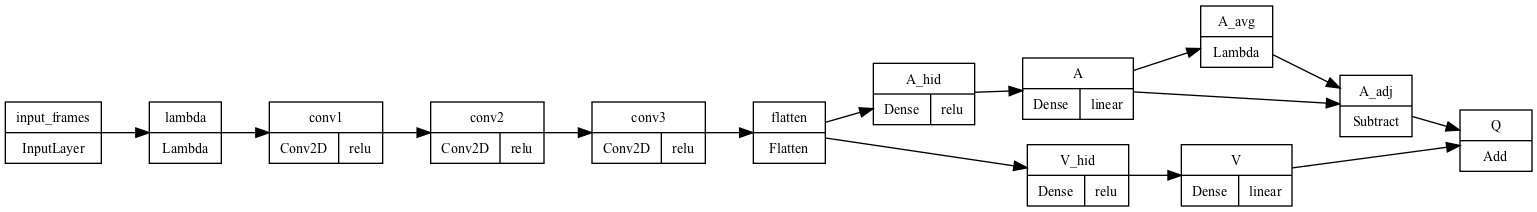

In [6]:
tf.keras.utils.plot_model(model, show_shapes=False, show_layer_activations=True, rankdir='LR')

In [8]:
mp_pool = mp.Pool(1)
t_lastmax = datetime.now()  # Time since last max train score (controls)
i_animation = 0  # Used to toggle between saliency types

for episode_num in range(episode_start, total_train_len):
    # Start a new game (episode)
    init_frame = env.reset()
    new_life = True
    game_over = False

    # Keep track of episode figures
    episode_reward = 0
    episode_train_cnt = 0
    episode_frames = []
    episode_states = []
    episode_actions = []
    episode_Qs = []
    episode_Vs = []
    episode_As = []
    episode_pZs = []
    episode_losses = []
    episode_tderrs = []

    # SI specific: skip first 20 frames when new game (40 in total with new-life line)
    for _ in range(20):
        env.step(0)

    # Play episode until game over
    while not game_over:
        if new_life:
            # SI specific: skip first 20 frames when new life
            for _ in range(20):
                env.step(0)

            for _ in range(random.randint(1, 15)):
                # Random initialization, to reduce overfitting
                frame, _, game_over, info = env.step(sample_ran_action(action_space))
            
            lives = info['ale.lives']
            frame_pp = preprocess_frame_v4(frame, crop_lims)  # Maxpooling not needed for first frame
            state = np.stack(state_len * [frame_pp], axis=2)
            
        # Select action
        eps = get_lin_anneal_eps(frame_num - replay_init_sz, eps_init, eps_final, eps_final_frame)
        eps = eps if init_done else 1
        action, Q, V, A, pZ = choose_action(
            model_action, state, action_space, eps, duel_net, distr_net, Z
        )
        
        # Store state and actions variables
        episode_frames.append(frame)
        episode_states.append(state)
        episode_actions.append(action)
        episode_Qs.append(Q)
        episode_Vs.append(V)
        episode_As.append(A)
        episode_pZs.append(pZ)
        
        # Take action and observe transition
        prev_frame = frame  # Keep previous frame for max pooling step
        frame, reward, game_over, info = env.step(action)
        
        # Process env response
        frame_pp = frame_max_pooling([prev_frame, frame])
        frame_pp = preprocess_frame_v4(frame_pp, crop_lims)
        state = np.append(state[:, :, 1:], frame_pp[:, :, None], axis=2)
        # reward = clip_reward(reward)
        new_life = info['ale.lives'] < lives 
        lives = info['ale.lives']
        
        # Add new transition to replay memory
        transition = (action, reward, game_over or new_life, new_life, frame_pp)  # TODO: inspect game + life
        replay_mem.store_memory(transition)
                
        # Increase transition counters
        frame_num += 1
        episode_reward += reward
        init_done = frame_num >= replay_init_sz  # Is replay initializing done
                    
        # After init period start replay transitions and train model
        if init_done:
            
            # # Initialize td-errors of init replay mems
            # if init_tds and frame_num == replay_init_sz:
            #     replay_init_idxs = range(replay_init_sz)
            #     replay_init_ps = replay_mem.get_priorities(replay_init_idxs)
            #     replay_init_idxs = np.flatnonzero(replay_init_ps)
            #     replay_init_mems = replay_mem.get_memories(replay_init_idxs, n_step)[:-1]
            #     replay_init_td_errs = td_error(model, model_tgt, action_space, disc_rate, *replay_init_mems)
            #     replay_mem.update_priorities(replay_init_idxs, replay_init_td_errs)

            # Train model every train_interval
            if frame_num % train_interval == 0:
                mini_batch = replay_mem.get_sample(batch_sz)
                batch_idxs, mini_batch = mini_batch[-1], mini_batch[:-1]
                w_imps = replay_mem.get_imps_weights(batch_idxs)
                
                if distr_net:
                    batch_td_errs, loss = fit_batch_DDQNn_PER_DS(
                        model, model_tgt, action_space, disc_rate, *mini_batch, w_imps, 
                        Z, Z_repN, dZ, (V_min, V_max), noisy_net, double_learn
                    )
                else:
                    batch_td_errs, loss = fit_batch_DDQNn_PER(
                        model, model_tgt, action_space, disc_rate, *mini_batch, 
                        w_imps, noisy_net, double_learn
                    )
                replay_mem.update_priorities(batch_idxs, batch_td_errs)
                # Is there balance between updating ps and having new ps set to max? will updated ps stand a chance?
                episode_train_cnt += 1
                episode_losses.append(loss)
                episode_tderrs.append(np.mean(batch_td_errs))

            # Update target model
            if frame_num % tgt_update_interval == 0:
                model_tgt.set_weights(model.get_weights())

    # Log episode statistics
    ep_log.append(
        episode_num, episode_train_cnt, frame_num, episode_reward, 
        episode_actions, episode_Qs, episode_losses, episode_tderrs
    )

    # Variables to control output frequency
    run_anim_reg = episode_num % 1000 == 0
    run_anim_max = (episode_reward > max_episode_reward) & (datetime.now() > t_lastmax)
    backup_model = episode_num % 250 == 0

    # Output episode animation video every 1000 episodes
    # Also output episode video if new max score was attained, and time-delta has been met
    if run_anim_reg or run_anim_max:
        opath_anim = f'{model_dir}/record/{episode_num}_train_{episode_reward}.mp4'
        sal_type = 'gcam' if i_animation % 2 else 'sal'

        mp_pool.apply_async(animate_episode_sal, args=(
            model, episode_states, episode_frames, episode_actions, 
            episode_Qs, episode_Vs, episode_As, action_space, opath_anim, 
            duel_net, distr_net, (Z, episode_pZs), sal_type)
        )
        i_animation += 1
        if run_anim_max:
            t_lastmax = datetime.now() + timedelta(minutes=30)
            max_episode_reward = episode_reward
        
    # Backup model and replay memory every 250 episodes
    # Note: takes a minute or two, so should not be run frequently 
    if backup_model:
        joblib.dump(replay_mem, opath_mem, compress=3)
        model.save(opath_model)


../script/utils.py:146: RuntimeWarning: Mean of empty slice
  np.nanmean(np.max(Qs, axis=1)),
/Users/dionjoren/opt/anaconda3/envs/tf-pip-cp-2.12.0/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dionjoren/opt/anaconda3/envs/tf-pip-cp-2.12.0/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dionjoren/opt/anaconda3/envs/tf-pip-cp-2.12.0/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
2024-02-02 00:51:22.029960: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using t

INFO:tensorflow:Assets written to: ram://ce3f04d0-3e05-474b-a126-1855318a47e4/assets


/Users/dionjoren/opt/anaconda3/envs/tf-pip-cp-2.12.0/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/dionjoren/opt/anaconda3/envs/tf-pip-cp-2.12.0/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
../script/utils.py:146: RuntimeWarning: Mean of empty slice
  np.nanmean(np.max(Qs, axis=1)),
/Users/dionjoren/opt/anaconda3/envs/tf-pip-cp-2.12.0/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dionjoren/opt/anacon

In [ ]:
@tf.function  # Somehow this causes y_pred to have slightly different decimals
def train_on_batch(model, x, y_tgt, actions, tgt_zeroing=False, sample_weight=None):
    with tf.GradientTape() as tape:
        # Forward pass, keep only pred values for actions actually taken
        y_pred = model(x, training=True)
        indices = tf.expand_dims(actions, -1)  # 1D to 2D
        y_pred = tf.expand_dims(tf.gather_nd(y_pred, indices, batch_dims=1), -1)
        loss = model.loss(y_tgt, y_pred, sample_weight=sample_weight)
        
    # Backward pass
    grads = tape.gradient(loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return y_pred, loss

@tf.function  # Somehow this causes y_pred to have slightly different decimals
def train_on_batch2(model, x, y_tgt, actions, tgt_zeroing=False, sample_weight=None):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)

        # Set target such that updates are only executed for those actions taken,
        # i.e. one action per each sample
        shape = y_pred.get_shape()
        indices = tf.stack([tf.range(shape[0]), actions], axis=1)
        if tgt_zeroing:
            y_tgt = tf.scatter_nd(indices, y_tgt, shape)  # Set all but the update values to 0
        else:
            y_tgt = tf.tensor_scatter_nd_update(y_pred, indices, y_tgt)  # Set all but the update values to y_pred
        loss = model.loss(y_tgt, y_pred, sample_weight=sample_weight)
        
    # Backward pass
    grads = tape.gradient(loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return y_pred, loss

from atari_model import abs_td_error

In [ ]:
state_now, action, rewards, game_over, state_next = mini_batch
x = np.stack(state_now)
action = action.astype('int32')

tf.random.set_seed(seed)
model1 = atari_model_dueling(M, lr, state_shape, kernel_init, noisy_net, large_net)
tf.random.set_seed(seed)
model2 = atari_model_dueling(M, lr, state_shape, kernel_init, noisy_net, large_net)

In [ ]:
Q_next_tgt = model1(x).numpy()
Q_next_tgt_max = Q_next_tgt.max(axis=1, keepdims=True)
n = 3
R_n = (np.stack(rewards)).sum(axis=1, keepdims=True)  # n-step forward return
Q_now_tgt = np.float32(R_n + Q_next_tgt_max)  # Has dims (batch_sz, 1)
pred1, l1 = train_on_batch(model1, x, Q_now_tgt, action, sample_weight=w_imps)
td1 = abs_td_error(pred1, Q_now_tgt)

In [ ]:
Q_next_tgt = model1(x).numpy()
Q_next_tgt_max = Q_next_tgt.max(axis=1, keepdims=True)
n = 3
R_n = (np.stack(rewards)).sum(axis=1, keepdims=True)  # n-step forward return
Q_now_tgt = np.float32(R_n + Q_next_tgt_max)  # Has dims (batch_sz, 1)

In [ ]:
Q_next_tgt = model1(x).numpy()
Q_next_tgt_max = Q_next_tgt.max(axis=1)
n = 3
R_n = (np.stack(rewards)).sum(axis=1)  # n-step forward return
Q_now_tgt2 = np.float32(R_n + Q_next_tgt_max)  # Has dims (batch_sz, 1)

In [ ]:
Q_next_tgt[range(32),Q_next_tgt.argmax(axis=1), None]

array([ 0.16592658,  0.06072769,  0.09493752,  0.16158016,  0.05259099,
        0.10843253,  0.23562898,  0.16574259,  0.0614053 ,  0.05316041,
       -0.09435908,  0.13099879,  0.09184173,  0.21896473,  0.26399025,
        0.17539315,  0.19559202,  0.10241026,  0.11359905,  0.10644329,
        0.19914463,  0.09802823,  0.07264499,  0.2231821 ,  0.11533904,
        0.14305255,  0.10845242,  0.11606859,  0.16778196,  0.04622375,
        0.09634934,  0.199819  ], dtype=float32)

In [ ]:
Q_now_tgt.shape, Q_now_tgt2.shape

((32, 1), (32,))

In [ ]:
Q_now_tgt2 == Q_now_tgt.ravel()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [ ]:
def f1(model, x, y_tgt, actions, tgt_zeroing=False, sample_weight=None):
    with tf.GradientTape() as tape:
        # Forward pass, keep only pred values for actions actually taken
        y_pred = model(x, training=True)
        indices = tf.expand_dims(actions, -1)  # 1D to 2D
        y_pred = tf.expand_dims(tf.gather_nd(y_pred, indices, batch_dims=1), -1)
        # y_pred = tf.gather_nd(y_pred, indices, batch_dims=1)
        loss = Huber(reduction='auto')(y_tgt, y_pred, sample_weight=sample_weight)
        # loss = model.loss(y_tgt, y_pred) / 6
    return loss, y_pred

def f11(model, x, y_tgt, actions, tgt_zeroing=False, sample_weight=None):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        indices = tf.expand_dims(actions, -1)  # 1D to 2D
        y_pred = tf.expand_dims(tf.gather_nd(y_pred, indices, batch_dims=1), -1)
        loss = Huber()(y_tgt, y_pred, sample_weight=sample_weight) / 6
    return loss, y_pred

def f2(model, x, y_tgt, actions, sample_weight=None):
    with tf.GradientTape() as tape:
        # Forward pass, keep only pred values for actions actually taken
        y_pred = model(x, training=True)
        shape = y_pred.get_shape()
        indices = tf.stack([tf.range(shape[0]), actions], axis=1)
        y_tgt = tf.tensor_scatter_nd_update(y_pred, indices, y_tgt)  # Set all but the update values to y_pred
        loss = Huber(reduction='auto')(y_tgt, y_pred, sample_weight=sample_weight)
    return loss, y_pred

In [ ]:
(
    f1(model, x, Q_now_tgt, action, sample_weight=w_imps)[0].numpy().mean(),
    f2(model, x, Q_now_tgt2, action, sample_weight=w_imps)[0].numpy().mean() * 6,
)

(1.2136731, 1.2136731147766113)

In [ ]:
(
    f1(model, x, Q_now_tgt, action, sample_weight=w_imps)[0] / 6,
    f2(model, x, Q_now_tgt2, action, sample_weight=w_imps)[0]
)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.20227885>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.20227885>)

In [ ]:
(
    np.mean(f1(model, x, Q_now_tgt, action, sample_weight=w_imps)[0]) / 6,
    f11(model, x, Q_now_tgt, action, sample_weight=w_imps)[0],
    f2(model, x, Q_now_tgt2, action, sample_weight=w_imps)[0],
)

(0.20227885246276855,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.20227885>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.20227885>)

In [ ]:
Q_now_tgt

array([[ 1.61145270e-01],
       [ 2.14669779e-02],
       [ 1.51709528e+01],
       [ 2.03712583e-02],
       [ 7.61484280e-02],
       [ 1.24149077e-01],
       [-2.64927745e-04],
       [ 7.15637766e-03],
       [ 1.24165490e-01],
       [ 1.84970409e-01],
       [ 2.32546568e-01],
       [ 8.24995190e-02],
       [ 1.99180454e-01],
       [-4.14049998e-02],
       [ 9.58715081e-02],
       [ 3.31913888e-01],
       [ 2.30275244e-01],
       [-1.04053795e-01],
       [ 1.69075131e-01],
       [ 1.46381915e-01],
       [ 8.78487974e-02],
       [ 3.02403030e+01],
       [ 1.76405251e-01],
       [ 1.73055053e-01],
       [ 8.26931596e-02],
       [ 2.72347212e-01],
       [ 6.14454076e-02],
       [-1.06498674e-02],
       [ 9.83160138e-02],
       [ 4.20964956e-02],
       [ 2.38716155e-02],
       [ 6.01409897e-02]], dtype=float32)

In [ ]:
x = np.stack(state_now)
l1, y1 = f1(model, x, Q_now_tgt2, action)
l2, y2 = f1(model, x, Q_now_tgt, action)
l1, l2

(<tf.Tensor: shape=(), dtype=float32, numpy=0.23136456>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.23083226>)

In [ ]:
x = np.stack(state_now)
l1, y1 = f1(model, x, Q_now_tgt, action, sample_weight=w_imps[:, None])
l2, y2 = f1(model, x, Q_now_tgt, action, sample_weight=w_imps)
l1, l2

(<tf.Tensor: shape=(), dtype=float32, numpy=0.23083226>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.23083226>)

In [ ]:
np.all(y1 == y2)

True

In [ ]:
model.loss(Q_now_tgt, y1), model.loss(Q_now_tgt2, y1)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.3849936>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.3881874>)

In [ ]:
(Q_now_tgt - y1).numpy()#, (Q_now_tgt2 - y1).numpy().mean()

array([[-1.12501681e-01],
       [-7.45910034e-02],
       [ 1.50615225e+01],
       [ 1.90830100e-02],
       [-9.80816111e-02],
       [-6.57125637e-02],
       [-1.47648066e-01],
       [-1.10246770e-01],
       [-1.43623993e-01],
       [-1.27182752e-01],
       [-3.51558328e-02],
       [-3.75804380e-02],
       [-1.18977040e-01],
       [-1.00912228e-01],
       [-1.54760629e-01],
       [-5.00906706e-02],
       [ 2.04010308e-03],
       [-5.47601953e-02],
       [-5.23475409e-02],
       [-2.22518742e-02],
       [-4.08160239e-02],
       [ 3.01076927e+01],
       [-1.92460716e-02],
       [-8.39561224e-03],
       [-1.54348016e-01],
       [ 2.75989383e-01],
       [-5.02593294e-02],
       [-4.67834175e-02],
       [-1.42308667e-01],
       [-8.12738985e-02],
       [-6.35515302e-02],
       [-2.19991803e-02]], dtype=float32)

In [ ]:
(Q_now_tgt2 - y1).numpy()

array([[-0.11250168, -0.25217998, 14.8973055 , ..., -0.23155046,
        -0.24977534, -0.21350595],
       [ 0.06508729, -0.074591  , 15.074895  , ..., -0.05396149,
        -0.07218637, -0.03591699],
       [ 0.05171499, -0.08796331, 15.0615225 , ..., -0.06733379,
        -0.08555867, -0.04928929],
       ...,
       [ 0.03777488, -0.10190342, 15.047583  , ..., -0.0812739 ,
        -0.09949878, -0.0632294 ],
       [ 0.07372212, -0.06595617, 15.083529  , ..., -0.04532665,
        -0.06355153, -0.02728216],
       [ 0.0790051 , -0.06067319, 15.088813  , ..., -0.04004367,
        -0.05826855, -0.02199918]], dtype=float32)

In [ ]:
td1

array([3.02156162e+01, 2.25859314e-01, 1.21854492e-01, 3.39083374e-03,
       3.04274231e-01, 3.09470028e-01, 1.36214793e-01, 2.88032115e-01,
       2.51581612e+01, 4.84219566e-02, 1.15301386e-01, 2.02334061e-01,
       1.50000000e+01, 3.01987228e+01, 1.50000000e+01, 5.26766300e+00,
       2.00197334e+01, 1.39158517e-01, 1.60349786e-01, 1.50000000e+01,
       1.30929261e-01, 0.00000000e+00, 2.20590476e-02, 2.03035984e+01,
       1.18493751e-01, 5.38515568e+00, 3.09257656e-01, 5.21540642e-08,
       2.02161064e+01, 2.12894157e-01, 2.31461108e-01, 4.33051765e-01],
      dtype=float32)

In [ ]:
Q_next_tgt = model2(x).numpy()
Q_next_tgt_max = Q_next_tgt.max(axis=1, keepdims=False)
n = 3
R_n = (np.stack(rewards)).sum(axis=1, keepdims=False)  # n-step forward return
Q_now_tgt = np.float32(R_n + Q_next_tgt_max)  # Has dims (batch_sz, 1)
pred2, l2 = train_on_batch2(model2, x, Q_now_tgt, action, sample_weight=w_imps)

NameError: name 'model2' is not defined

In [ ]:
td2 = abs_td_error(pred2.numpy()[range(batch_sz), action] , Q_now_tgt)
td2

array([3.02156162e+01, 2.25859314e-01, 1.21854492e-01, 3.39083374e-03,
       3.04274231e-01, 3.09470028e-01, 1.36214793e-01, 2.88032115e-01,
       2.51581612e+01, 4.84219566e-02, 1.15301386e-01, 2.02334061e-01,
       1.50000000e+01, 3.01987228e+01, 1.50000000e+01, 5.26766300e+00,
       2.00197334e+01, 1.39158517e-01, 1.60349786e-01, 1.50000000e+01,
       1.30929261e-01, 0.00000000e+00, 2.20590476e-02, 2.03035984e+01,
       1.18493751e-01, 5.38515568e+00, 3.09257656e-01, 5.21540642e-08,
       2.02161064e+01, 2.12894157e-01, 2.31461108e-01, 4.33051765e-01],
      dtype=float32)

In [ ]:
for _ in range(50):
    Q_next_tgt = model1(x).numpy()
    Q_next_tgt_max = Q_next_tgt.max(axis=1, keepdims=True)
    n = 3
    R_n = (np.stack(rewards)).sum(axis=1, keepdims=True)  # n-step forward return
    Q_now_tgt = np.float32(R_n + Q_next_tgt_max)  # Has dims (batch_sz, 1)
    print(train_on_batch(model1, x, Q_now_tgt, action, sample_weight=w_imps)[1])

tf.Tensor(6.135637, shape=(), dtype=float32)
tf.Tensor(6.127363, shape=(), dtype=float32)
tf.Tensor(6.121019, shape=(), dtype=float32)
tf.Tensor(6.1173587, shape=(), dtype=float32)
tf.Tensor(6.117865, shape=(), dtype=float32)
tf.Tensor(6.1197133, shape=(), dtype=float32)
tf.Tensor(6.124042, shape=(), dtype=float32)
tf.Tensor(6.130021, shape=(), dtype=float32)
tf.Tensor(6.1377068, shape=(), dtype=float32)
tf.Tensor(6.150482, shape=(), dtype=float32)
tf.Tensor(6.1717005, shape=(), dtype=float32)
tf.Tensor(6.2066145, shape=(), dtype=float32)
tf.Tensor(6.2594137, shape=(), dtype=float32)
tf.Tensor(6.335909, shape=(), dtype=float32)
tf.Tensor(6.4283876, shape=(), dtype=float32)
tf.Tensor(6.522491, shape=(), dtype=float32)
tf.Tensor(6.6542797, shape=(), dtype=float32)
tf.Tensor(6.8238497, shape=(), dtype=float32)
tf.Tensor(7.098086, shape=(), dtype=float32)
tf.Tensor(7.4091024, shape=(), dtype=float32)
tf.Tensor(8.271431, shape=(), dtype=float32)
tf.Tensor(8.68379, shape=(), dtype=float32)
t

In [ ]:
for _ in range(50):
    Q_next_tgt = model2(x).numpy()
    Q_next_tgt_max = Q_next_tgt.max(axis=1, keepdims=False)
    n = 3
    R_n = (np.stack(rewards)).sum(axis=1, keepdims=False)  # n-step forward return
    Q_now_tgt = np.float32(R_n + Q_next_tgt_max)  # Has dims (batch_sz, 1)
    print(train_on_batch2(model2, x, Q_now_tgt, action, sample_weight=w_imps)[1])

tf.Tensor(6.146886, shape=(), dtype=float32)
tf.Tensor(6.144699, shape=(), dtype=float32)
tf.Tensor(6.142667, shape=(), dtype=float32)
tf.Tensor(6.140784, shape=(), dtype=float32)
tf.Tensor(6.1390414, shape=(), dtype=float32)
tf.Tensor(6.137376, shape=(), dtype=float32)
tf.Tensor(6.135777, shape=(), dtype=float32)
tf.Tensor(6.1342688, shape=(), dtype=float32)
tf.Tensor(6.1328516, shape=(), dtype=float32)
tf.Tensor(6.13151, shape=(), dtype=float32)
tf.Tensor(6.1302347, shape=(), dtype=float32)
tf.Tensor(6.1289864, shape=(), dtype=float32)
tf.Tensor(6.1278276, shape=(), dtype=float32)
tf.Tensor(6.12673, shape=(), dtype=float32)
tf.Tensor(6.1257033, shape=(), dtype=float32)
tf.Tensor(6.124819, shape=(), dtype=float32)
tf.Tensor(6.124154, shape=(), dtype=float32)
tf.Tensor(6.123536, shape=(), dtype=float32)
tf.Tensor(6.1231728, shape=(), dtype=float32)
tf.Tensor(6.1228895, shape=(), dtype=float32)
tf.Tensor(6.122612, shape=(), dtype=float32)
tf.Tensor(6.1223927, shape=(), dtype=float32)
tf

In [ ]:
# 11.5 - 3 compr GB for 4508 episodes

In [ ]:
a = np.array([[1], [2]])

In [ ]:
@tf.function  # Somehow this causes y_pred to have slightly different decimals
def train_on_batch(model, x, y_tgt, actions, tgt_zeroing=False, sample_weight=None):
    with tf.GradientTape() as tape:
        # Forward pass, keep only pred values for actions actually taken
        y_pred = model(x, training=True)
        indices = tf.expand_dims(actions, -1)  # 1D to 2D
        y_pred = tf.expand_dims(tf.gather_nd(y_pred, indices, batch_dims=1), -1)
        loss = model.loss(y_tgt, y_pred, sample_weight=sample_weight)
        
    # Backward pass
    grads = tape.gradient(loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return y_pred, loss

In [ ]:
state_now, action, rewards, game_over, state_next = mini_batch
x = np.stack(state_now)
action = action.astype('int32')

In [ ]:
# model_tgt = clone_model(model)
# model_tgt.set_weights(model.get_weights())

In [ ]:
Q_next_tgt = model(x).numpy()
Q_next_tgt_max = Q_next_tgt.max(axis=1, keepdims=True)
n = 3
R_n = (np.stack(rewards)).sum(axis=1, keepdims=True)  # n-step forward return
Q_now_tgt = np.float32(R_n + Q_next_tgt_max)  # Has dims (batch_sz, 1)
train_on_batch(model, x, Q_now_tgt, action)

(<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
 array([[1.0627561 ],
        [0.8938535 ],
        [0.6220055 ],
        [0.4317693 ],
        [0.63995767],
        [1.0317239 ],
        [0.48084933],
        [0.692519  ],
        [0.70803404],
        [0.49818942],
        [0.8305197 ],
        [1.0515336 ],
        [0.95167315],
        [0.93536884],
        [0.88220966],
        [0.82973146],
        [0.543817  ],
        [0.8471759 ],
        [0.74581546],
        [0.7531091 ],
        [0.70619166],
        [0.97358567],
        [0.36639675],
        [0.7019837 ],
        [0.5633619 ],
        [0.7633652 ],
        [0.57345474],
        [0.7209159 ],
        [0.99736494],
        [0.8776028 ],
        [0.9415817 ],
        [0.6316835 ]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.102832>)

In [ ]:
tgt = model(np.stack(state_next)).numpy()[:, 0].astype('float32')

In [ ]:
Q_next_tgt = model(np.stack(state_next)).numpy()
Q_next_tgt_max = Q_next_tgt.max(axis=1, keepdims=True)

# Set Q target. We only want to run SGD updates for those actions taken
n = 3
R_n = (np.stack(rewards)).sum(axis=1, keepdims=True)  # n-step forward return
Q_now_tgt = np.float32(R_n + Q_next_tgt_max)  # Has dims (batch_sz, 1)
Q_now_tgt.shape

(32, 1)

In [ ]:
R_n[:, None]

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [30.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [20.],
       [ 0.],
       [ 0.]], dtype=float16)

In [ ]:
@tf.function  # Somehow this causes y_pred to have slightly different decimals
def train_on_batch(model, x, y_tgt, actions, tgt_zeroing=False, sample_weight=None):
    with tf.GradientTape() as tape:
        # Forward pass, keep only pred values for actions actually taken
        y_pred = model(x, training=True)
        indices = tf.stack([tf.range(y_pred.get_shape()[0]), actions], axis=1)
        y_pred = tf.gather_nd(y_pred, indices)
        print(y_pred.shape, y_tgt.shape, len(sample_weight))
        loss = model.loss(y_tgt, y_pred, sample_weight=sample_weight)
        
    # Backward pass
    grads = tape.gradient(loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return y_pred, loss